<a href="https://colab.research.google.com/github/patriciaquinones/Robot-Trading/blob/main/RobotTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1.Configuración del ambiente**

In [604]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.12
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.23.5
------
Name: matplotlib
Version: 3.7.1


In [605]:
import matplotlib.pyplot as plt
import seaborn as sns

####**Variables Globales**

In [606]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, df_bitcoin_limpio, codicia

#**2.Obtención de datos**

In [607]:
def importar_base_bitcoin():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision
  import pandas as pd
  import yfinance as fy
  import datetime

  bitcoin = "BTC-USD"

  #Se procede a calcular para obtener los datos de los ultimos 7 dias hasta la fecha
  fecha_final = datetime.datetime.now()
  fecha_inicial = fecha_final - datetime.timedelta(days=7)

  #Se extraen los datos desde los ultimos 7 dias con un intervalo de 5 minutos
  datos = fy.download(bitcoin, start=fecha_inicial, end=fecha_final, interval="5m")

  #Procedemos a convertirlo a un dataframe usando la variable global
  df_bitcoin = pd.DataFrame(datos)

importar_base_bitcoin()
df_bitcoin.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-10-12 04:00:00+00:00,26842.224609,26842.224609,26832.160156,26832.160156,26832.160156,0
2023-10-12 04:05:00+00:00,26827.603516,26827.603516,26821.388672,26823.316406,26823.316406,0
2023-10-12 04:10:00+00:00,26824.158203,26824.158203,26819.414062,26821.054688,26821.054688,0
2023-10-12 04:15:00+00:00,26828.539062,26828.664062,26823.912109,26828.664062,26828.664062,0
2023-10-12 04:20:00+00:00,26822.533203,26841.695312,26822.533203,26838.943359,26838.943359,0


Extrayendo el histórico de los últimos 7 días en intervalos de 5 minutos de los precios del Bitcoin en dólares BTC-USD, esto guardado en el dataframe df_bitcoin.

####2.1.Webscraping

In [608]:
def extraer_tendencias():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, codicia
  from bs4 import BeautifulSoup
  import requests

  headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/118.0'}
  url = 'https://coinmarketcap.com/'
  respuesta = requests.get(url, headers=headers)
  s=BeautifulSoup(respuesta.content, features='lxml')

  precio_actual = float(s.find('div', {'class':'sc-a0353bbc-0 gDrtaY'}).text.replace('$', '').replace(',', ''))
  ultima_hora = s.findAll('span', {'class' : 'sc-d55c02b-0'}) #Esta es la variacion en la ultima hora

  for clases in ultima_hora:
    clase = clases['class']

    if 'iwhBxy' in clase:
      tendencia = 'alta'
      break
    elif 'gUnzUB' in clase:
      tendencia = 'baja'
      break

  #Agregada para mejorar la toma de decisiones
   #(Un nivel de codicia de 40 a 60 se encuentra neutral, nivel > 60 = alta codicia por lo que es bueno comprar por buena reputacion o noticias y nivel < 40 = lo ideal es vender por la mala reputacion)
  codicia = s.find('span', {'class' : 'sc-16891c57-0 OKpOL base-text'}).text.split('/')
  codicia = int(codicia[0])
  print(f'El precio actual del bitcoin es de {precio_actual}, su variación es {tendencia} y el nivel de codicia actualmente es {codicia}% de 100%')

extraer_tendencias()

El precio actual del bitcoin es de 28247.94, su variación es alta y el nivel de codicia actualmente es 47% de 100%


#**3.Limpieza de Datos**

Valores nulos encontrados sin tratar: 0
Valores nulos encontrados despues de tratar: 0
Valores nulos detectados en el dataframe original 0 y la copia 0
La cantidad de ceros encontrados en el volumen sin tratar son: 1067
No se encontraron ceros en el volumen despues de tratar
El promedio del Bitcoin actualmente es de: 27573.16


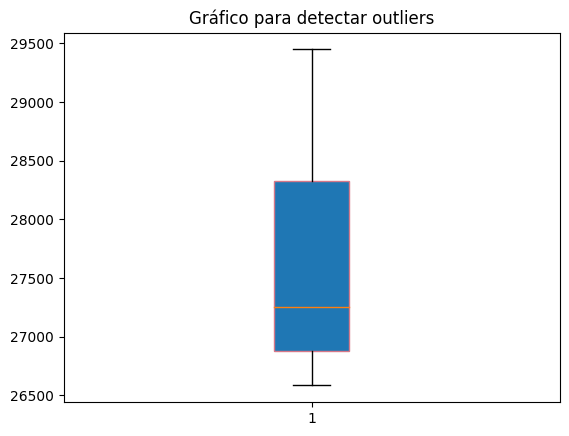

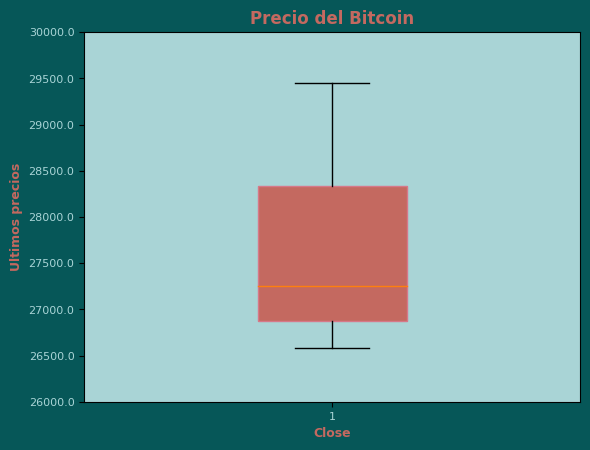

In [609]:
def limpieza_datos():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, df_bitcoin_limpio

  #Se realiza una copia del dataframe original para evitar alterar el mismo.
  df_bitcoin_limpio = df_bitcoin.copy()

  #Detectamos los duplicados y lo asignamos a una variable
  duplicados = df_bitcoin_limpio.duplicated()

  #Procedemos a eliminar los duplicados
  df_bitcoin_limpio.index = df_bitcoin_limpio.index[~duplicados].unique()

  #Identificamos si la columna Close tiene valores nulos
  print(f'Valores nulos encontrados sin tratar: {df_bitcoin_limpio.Close.isna().sum()}')

  #Tratamos los valores nulos en la columna Close
  df_bitcoin_limpio['Close'] = df_bitcoin_limpio['Close'].fillna(0)
  print(f'Valores nulos encontrados despues de tratar: {df_bitcoin_limpio.Close.isna().sum()}')

  #Realizamos comparaciones y detectamos que no hay valores nulos incluso en el original
  print(f'Valores nulos detectados en el dataframe original {df_bitcoin.Close.isna().sum()} y la copia {df_bitcoin_limpio.Close.isna().sum()}')

  #Verifimos si existen valores menores o iguales a cero en la columna Volume
  cantidad_ceros = (df_bitcoin_limpio['Volume'] <= 0).sum()
  print(f'La cantidad de ceros encontrados en el volumen sin tratar son: {cantidad_ceros}')

  #Procedemos a actualizar el dataframe dejando a la columna Volume solo con transacciones mayores a 0
  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]
  volume = (df_bitcoin_limpio['Volume'] <= 0).sum()
  if (volume > 0):
    print(f'La cantidad de ceros encontrados en el volumen despues de tratar: {volume}')
  else:
    print(f'No se encontraron ceros en el volumen despues de tratar')

  #Verificando presencia de Outliers en el precio del Bitcoin desde un boxplot
  plt.boxplot(df_bitcoin_limpio['Close'], boxprops={'color': '#d67889'}, patch_artist=True)
  plt.title('Gráfico para detectar outliers')

  #Identificando cuartiles
  Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
  Q3 = df_bitcoin_limpio['Close'].quantile(0.75)
  IQR = Q3 - Q1

  #Identificando outliers
  outliers = (df_bitcoin_limpio['Close'] < Q1 - 1.5 * IQR) | (df_bitcoin_limpio['Close'] > Q3 + 1.5 * IQR)

  #Cambiando el color de fondo de fuera
  fig = plt.figure(facecolor='#065758')

  #Para cambiar el color de fondo
  ejes = plt.gca()
  ejes.set_facecolor('#a9d4d6')

  #Filtro para obtener unicamente los registros entre Q1 y Q3 y asi eliminar los outliers
  df_bitcoin_limpio_filtrado = df_bitcoin_limpio[~outliers]
  box = plt.boxplot(df_bitcoin_limpio_filtrado['Close'], boxprops={'color': '#d67889'}, patch_artist=True, widths=0.3)

  #Ajustando colores del boxplot
  for box_item in box['boxes']:
    box_item.set(facecolor='#c46960', edgecolor='#d67889')

  #Color de texto de los valores
  ejes.set_xticklabels(ejes.get_xticks(), color='#a9d4d6', fontsize=8)
  ejes.set_yticks(ejes.get_yticks())
  ejes.set_yticklabels(ejes.get_yticks(), color='#a9d4d6', fontsize=8)

  plt.title('Precio del Bitcoin', color='#c46960', fontweight='bold')
  plt.ylabel('Ultimos precios', color='#c46960', fontsize=9, fontweight='bold')
  plt.xlabel('Close', color='#c46960', fontsize=9, fontweight='bold')

  #Se procede a calcular el promedio del filtro realizado anteriormente
  media_bitcoin = round(df_bitcoin_limpio_filtrado['Close'].mean(), 2)
  print(f'El promedio del Bitcoin actualmente es de: {media_bitcoin}')

limpieza_datos()

#**4.Toma de Decisiones**

In [610]:
def tomar_decisiones():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, df_bitcoin_limpio, codicia

  if (precio_actual >= media_bitcoin) & (tendencia == 'baja') & (codicia < 40):
    algoritmo_decision = 'Vender'
  elif (precio_actual < media_bitcoin) & (tendencia == 'alta') & (codicia > 60):
    algoritmo_decision = 'Comprar'
  else:
    algoritmo_decision = 'Mantener'

  print(f'El algoritmo de decision le recomienda en este momento: {algoritmo_decision}')
tomar_decisiones()

El algoritmo de decision le recomienda en este momento: Mantener


#**5.Visualización**

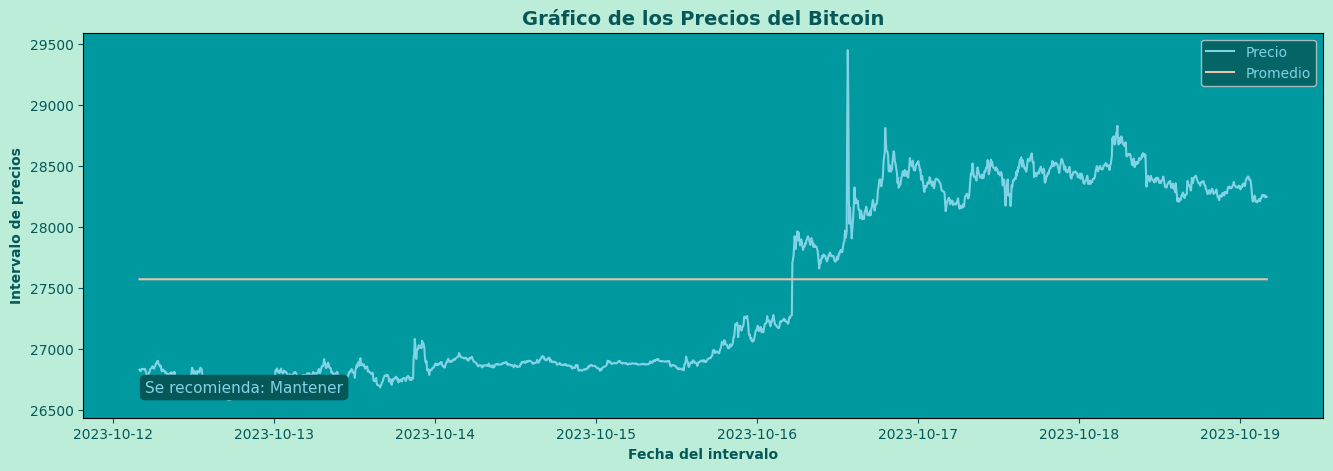

In [611]:
def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

  #Adiccionando nueva columna al dataframe original
  df_bitcoin['Promedio'] = media_bitcoin

  #Definiendo los datos
  x=df_bitcoin.index
  y=df_bitcoin['Close']
  z=df_bitcoin['Promedio']

  #Configuracion del tamano y color de fondo fuera del gráfico
  fig = plt.figure(figsize=(16, 5), facecolor='#bcedd8')
  plt.tick_params(axis='both', color='#065758')

  #Mostrando los datos a través de un plot
  plt.plot(x, y, label='Precio', color='#81d2e4')
  plt.plot(x, z, label='Promedio', color='#e9c1a6')

  #Cambiando el color de fondo del grafico
  ejes = plt.gca()
  ejes.set_facecolor('#00999f')

  #Color de texto de los valores(Datos)
  ejes.tick_params(axis='x', labelcolor='#065758')
  ejes.tick_params(axis='y', labelcolor='#065758')

  #Condición para cambiar el color del texto dependiendo del resultado del Algoritmo de decisión
  color = 'red' if algoritmo_decision == 'Vender' else '#81d2e4'
  plt.annotate('Se recomienda: {}'.format(algoritmo_decision), xy=(x[10], 26650), fontsize=11, color=color, bbox={'boxstyle': 'round', 'facecolor': '#065758', 'edgecolor': '#065758'})

  plt.title('Gráfico de los Precios del Bitcoin', color='#065758', fontweight='bold', fontsize='14')
  plt.xlabel('Fecha del intervalo', color='#065758', fontweight='bold')
  plt.ylabel('Intervalo de precios', color='#065758', fontweight='bold')
  plt.legend(facecolor='#065758', labelcolor='#81d2e4')
  plt.show()

visualizacion()

#**6.Automatización**

[*********************100%%**********************]  1 of 1 completed
El precio actual del bitcoin es de 28248.18, su variación es alta y el nivel de codicia actualmente es 47% de 100%
Valores nulos encontrados sin tratar: 0
Valores nulos encontrados despues de tratar: 0
Valores nulos detectados en el dataframe original 0 y la copia 0
La cantidad de ceros encontrados en el volumen sin tratar son: 1066
No se encontraron ceros en el volumen despues de tratar
El promedio del Bitcoin actualmente es de: 27574.33
El algoritmo de decision le recomienda en este momento: Mantener


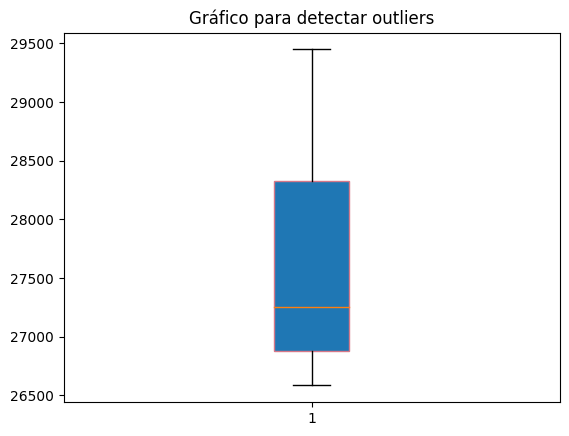

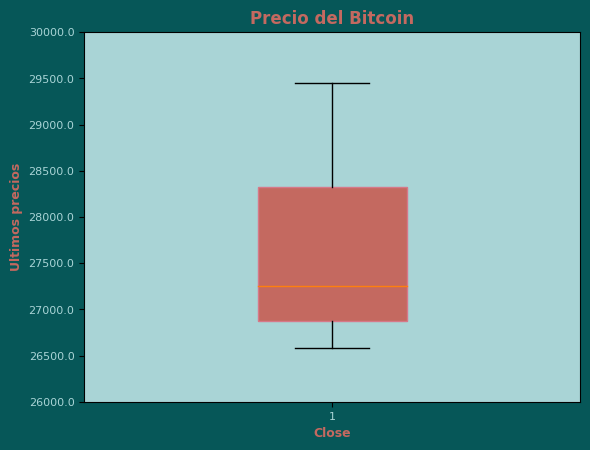

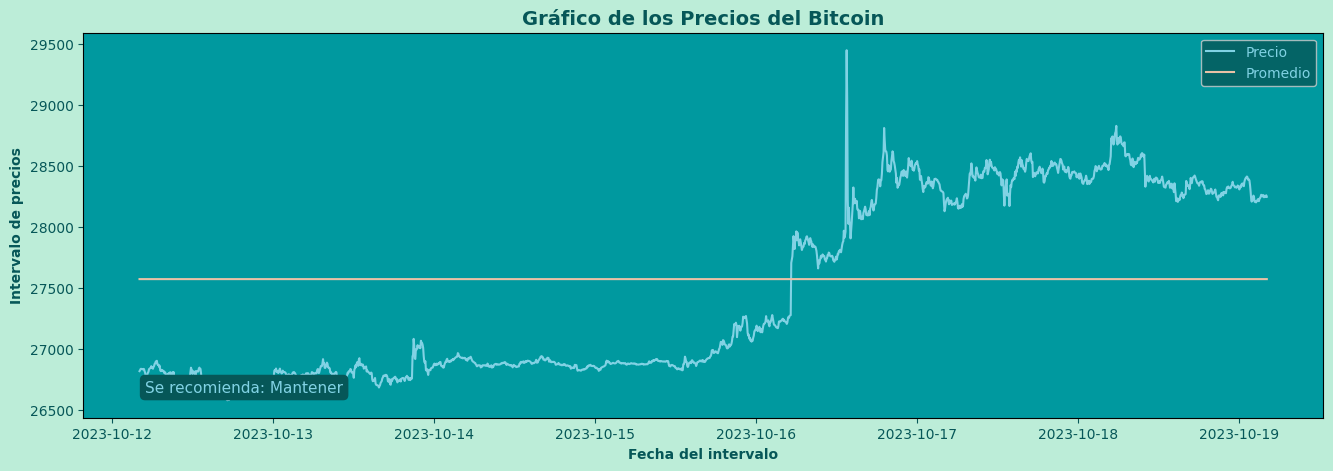

In [ ]:
from IPython.display import clear_output
import time
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)